<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2010%20-%20Unsupervised%20Representation%20Learning/Lecture10_AEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


# 128
img_size = 128
batch_size = 32
latent_dim = 256
epochs = 5

# LOAD DATASET FROM TFDS
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:30%]', 'train[30%:40%]'],  # first 10% for training, next 5% for validation
    with_info=True,
    as_supervised=True
)

# PREPROCESS FUNCTION
def preprocess(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, image  # autoencoder target = input

ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# AUTOENCODER MODEL
inputs = layers.Input(shape=(img_size, img_size, 3))

# -----------------------------
# ENCODER
# -----------------------------
c1 = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)  # 32x32
c2 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(c1)     # 16x16
c3 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(c2)    # 8x8

shape_before_flatten = c3.shape[1:]
flat_dim = int(tf.math.reduce_prod(shape_before_flatten))

x = layers.Flatten()(c3)
latent = layers.Dense(latent_dim, name='latent_vector')(x)

# DECODER WITH SKIP CONNECTIONS

x = layers.Dense(flat_dim)(latent)
x = layers.Reshape(shape_before_flatten)(x)

# Decoder layer 1: skip from c3
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Concatenate()([x, c2])  # skip connection from c2

# Decoder layer 2: skip from c1
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Concatenate()([x, c1])  # skip connection from c1

# Final decoder layer
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
outputs = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# TRAINING
history = autoencoder.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val
)



Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     18,496 │ conv2d_41[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16,    │     73,856 │ conv2d_42[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 32768)     │          0 │ conv2d_43[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_vector       │ (None, 256)       │  8,388,864 │ flatten_11[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32768)     │  8,421,376 │ latent_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 16, 16,    │          0 │ dense_25[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_27 │ (None, 32, 32,    │    147,584 │ reshape_9[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_28 │ (None, 64, 64,    │    110,656 │ concatenate_14[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ conv2d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_29 │ (None, 128, 128,  │     27,680 │ concatenate_15[0… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │        867 │ conv2d_transpose… │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,190,275 (65.58 MB)

 Trainable params: 17,190,275 (65.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - loss: 0.0292 - val_loss: 0.0034
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 9.7718e-04 - val_loss: 7.7702e-04
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 7.2252e-04 - val_loss: 6.2175e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


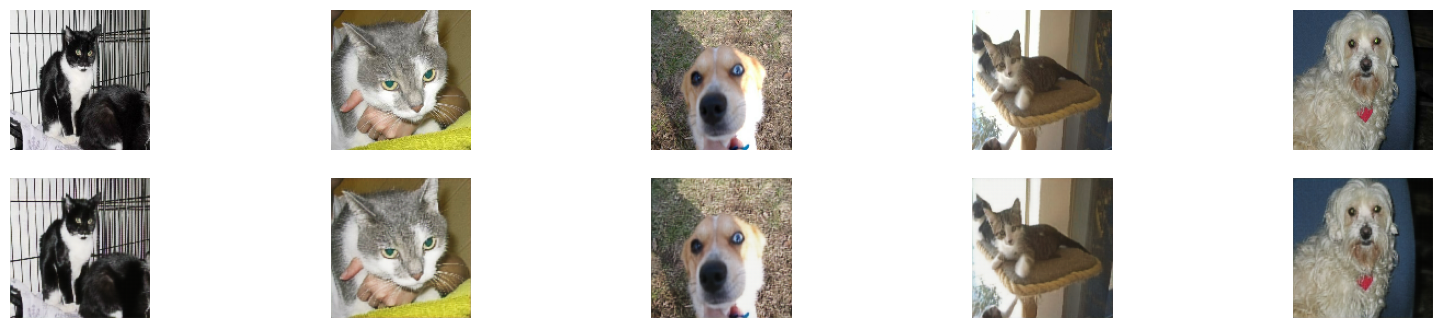

In [ ]:
# VISUALIZE RESULTS
for batch in ds_val.take(1):
    imgs, _ = batch
    decoded_imgs = autoencoder.predict(imgs[:5])
    plt.figure(figsize=(20, 4))
    for i in range(5):
        # Original
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(imgs[i])
        plt.axis('off')
        # Reconstructed
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(decoded_imgs[i])
        plt.axis('off')
    plt.show()
